## Notebook Mars solve for seismic detection

### Import libraries required

In [42]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

In [43]:
test_directory = './data/mars/test/data/'
test_files = []

for filename in os.listdir(test_directory):
    if filename.endswith('.csv'):
        test_files.append(filename)

WINDOW_SIZE = 2000
STEP_SIZE = 30
MEAN_AMPLITUDE_FACTOR = 1.1
MAX_AMPLITUDE_DEVIATION = 80

# Create a catalog DataFrame similar to moon solve
cat = pd.DataFrame({
    'filename': [f.replace('.csv', '') for f in test_files]
})

print(f"Found {len(test_files)} Mars seismic data files")
print(f"Catalog created with {len(cat)} entries")

Found 9 Mars seismic data files
Catalog created with 9 entries


### Configuration and Data Setup

This section defines the essential configuration parameters and data paths for the Mars seismic detection system. These settings control the behavior of the event detection algorithms and specify where to find the input data.

#### Data Directory Configuration:
- **`test_directory`**: Path to the Mars test data files
- **`test_files`**: List of available CSV files for analysis

#### Algorithm Parameters:
- **`WINDOW_SIZE = 2000`**: Size of the analysis window in data points
  - Controls the temporal resolution of event detection
  - Optimized for Mars seismic characteristics
  
- **`STEP_SIZE = 30`**: Step size for sliding window analysis
  - Determines the overlap between consecutive analysis windows
  - Provides fine temporal resolution for Mars data
  
- **`MEAN_AMPLITUDE_FACTOR = 1.1`**: Threshold multiplier for event end detection
  - Used to determine when a seismic event has ended
  - Events end when amplitude drops below this factor times the mean amplitude
  
- **`MAX_AMPLITUDE_DEVIATION = 80`**: Maximum allowed amplitude deviation filter
  - Filters out potential noise artifacts with extreme amplitude variations
  - Events with deviation coefficients above this value are rejected

In [44]:
# Power, bandwidth, spectral entropy, peak frequency, dominant frequency, centroid frequency, mean frequency and spectral amplitude

def get_power(dataframe):
    # The power of a signal is the sum of the squares of the absolute values of the signal's time-domain samples divided by the signal length
    data = dataframe.data

    return np.sum(np.abs(data)**2)

def get_bandwidth(dataframe):
    # The bandwidth of a signal is the range of frequencies that it contains
    data = dataframe.data
    fft = np.fft.fft(data)

    return np.sum(np.abs(fft)**2)

def get_highest_amplitude(dataframe):
    data = dataframe.data

    return np.max(np.abs(data))

def get_lowest_amplitude(dataframe):
    data = dataframe.data

    return np.min(np.abs(data))

def get_spectral_entropy(dataframe):
    data = dataframe.data

    fft = np.fft.fft(data)
    power = np.abs(fft)**2
    power = power / np.sum(power)  # Normalización
    power = power[power > 0]  # Evitar log(0)

    return -np.sum(power * np.log(power))

def get_spectral_amplitude(dataframe):
    data = dataframe.data

    fft = np.fft.fft(data)

    return np.max(np.abs(fft))

def get_mean_amplitude(dataframe):
    data = dataframe.data

    return np.mean(np.abs(data))

def get_characteristics(dataframe):
    return dict(
        # power=get_power(dataframe),
        # bandwidth=get_bandwidth(dataframe),
        mean_amplitude=get_mean_amplitude(dataframe),
        # spectral_entropy=get_spectral_entropy(dataframe),
        spectral_amplitude=get_spectral_amplitude(dataframe)
    )

def get_file_data(file: str):
    data = pd.read_csv(file)

    csv_times = np.array(data['rel_time(sec)'].tolist())
    csv_data = np.array(data['velocity(c/s)'].tolist())

    return pd.DataFrame(dict(
        time=csv_times,
        data=csv_data
    ))

def get_file_data_from_catalog(index: int):
    catalog_row = cat.iloc[index]
    filename = catalog_row.filename + '.csv'

    csv_file = f'{test_directory}{filename}'
    data_cat = pd.read_csv(csv_file)

    csv_times = np.array(data_cat['rel_time(sec)'].tolist())
    csv_data = np.array(data_cat['velocity(c/s)'].tolist())

    return pd.DataFrame(dict(
        time=csv_times,
        data=csv_data
    ))

def get_windowed_data(dataframe, offset=0, window_size=WINDOW_SIZE):
    result = []
    data = dataframe.data
    times = dataframe.time

    for i in range(offset, offset + window_size):
        if i >= len(data):
            break

        row = dict(
            time=times[i],
            data=data[i]
        )
        result.append(row)
    
    return pd.DataFrame(result)

def get_windows_characteristics(windows):
    characteristics = []

    for i in range(len(windows)):
        window = windows[i]

        characteristics.append(get_characteristics(window))
        print(f'Processed window {i}/{len(windows)}')

    return pd.DataFrame(characteristics)

def get_start_event_window(dataframe):
    max_spectral_amplitude = float('-inf')
    max_spectral_amplitude_index = 0

    dataframe_mean_amplitude = get_characteristics(dataframe)['mean_amplitude']

    for offset in range(0, len(dataframe), STEP_SIZE):
        window = get_windowed_data(dataframe, offset)
        characteristics = get_characteristics(window)

        if characteristics['spectral_amplitude'] > max_spectral_amplitude:
            min_max_amplitude_difference = np.abs(get_highest_amplitude(window) - get_lowest_amplitude(window))
            deviation_coefficient =  min_max_amplitude_difference / dataframe_mean_amplitude

            if deviation_coefficient > MAX_AMPLITUDE_DEVIATION:
                continue

            max_spectral_amplitude = characteristics['spectral_amplitude']
            max_spectral_amplitude_index = offset
    
    # Go back 1 windows to get the start of the event
    max_spectral_amplitude_index -= 2 * STEP_SIZE
    
    return get_windowed_data(dataframe, max_spectral_amplitude_index), max_spectral_amplitude_index

def get_end_event_window(dataframe, event_window_index):
    # Starting in the event time, get the first window that its mean amplitude is less than the mean amplitude of the event window

    window_mean_amplitude = get_characteristics(dataframe)['mean_amplitude'] * MEAN_AMPLITUDE_FACTOR

    for i in range(event_window_index, len(dataframe), STEP_SIZE):
        window = get_windowed_data(dataframe, i, WINDOW_SIZE)
        mean_amplitude = get_mean_amplitude(window)

        if mean_amplitude < window_mean_amplitude:
            return window, i

    return None, None

def get_event_dataframe(dataframe):
    _, start_event_window_index = get_start_event_window(dataframe)
    _, end_event_window_index = get_end_event_window(dataframe, start_event_window_index)

    result = dataframe.iloc[start_event_window_index:end_event_window_index]

    return result

def get_noiseless_data_from_file(file: str):
    data = get_file_data(file)

    return get_event_dataframe(data)

def remove_noise_from_file(file: str):
    data = get_file_data(file)
    event_data = get_event_dataframe(data)
    final_file = file.split('/')[-1]

    detect_df = pd.DataFrame(data = {
        "filename": [final_file for _ in range(len(event_data))],
        "rel_time(sec)": event_data.time,
        "velocity(c/s)": event_data.data
    })

    detect_df.to_csv(file.replace('.csv', '_NOISELESS.csv'), index=False)

### Signal Processing Functions

This section contains the core signal processing functions used for Mars seismic event detection and analysis. These functions extract various characteristics from seismic data to identify and classify Martian seismic events.

#### Feature Extraction Functions:
- **`get_power()`**: Calculates the total power of a signal using time-domain samples
- **`get_bandwidth()`**: Estimates signal bandwidth using frequency domain analysis
- **`get_highest_amplitude()` / `get_lowest_amplitude()`**: Find amplitude extremes
- **`get_spectral_entropy()`**: Measures spectral complexity and randomness
- **`get_spectral_amplitude()`**: Finds maximum spectral component amplitude
- **`get_mean_amplitude()`**: Calculates average signal amplitude

#### Data Processing Functions:
- **`get_characteristics()`**: Combines multiple features into a single analysis
- **`get_file_data()`**: Loads and processes CSV seismic data files
- **`get_file_data_from_catalog()`**: Loads data using catalog index
- **`get_windowed_data()`**: Extracts time windows from continuous data

#### Event Detection Functions:
- **`get_start_event_window()`**: Identifies the beginning of seismic events
- **`get_end_event_window()`**: Determines when seismic events end
- **`get_event_dataframe()`**: Extracts complete event data
- **`remove_noise_from_file()`**: Generates noise-filtered output files

In [45]:
def plot_test(index):
    file_index = index
    dataframe = get_file_data_from_catalog(file_index)

    start_event_window, start_event_window_index = get_start_event_window(dataframe)
    end_event_window, end_event_window_index = get_end_event_window(dataframe, start_event_window_index)

    print(f'Start event window: {start_event_window_index}')
    # print(f'End event window: {end_event_window_index}')
    times = dataframe.time
    data = dataframe.data

    # plot
    fig, ax = plt.subplots(1,1,figsize=(10,3))
    ax.plot(times, data)

    event_mean_amplitude = get_mean_amplitude(end_event_window)
    event_start_time = start_event_window.time.iloc[0]
    event_end_time = end_event_window.time.iloc[0]

    # Shadow the event window
    ax.axvspan(event_start_time, event_end_time, color='green', alpha=0.5)

    # Plot event mean amplitude
    ax.axhline(event_mean_amplitude, color='r', linestyle='--', label=f'Event mean amplitude ({event_mean_amplitude:.2f})')

    # Make the plot pretty
    ax.set_xlim([min(times), max(times)])
    ax.set_ylabel('Velocity (c/s)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f'File index {index}', fontweight='bold')

    # Plot where the event window is
    event_window_times = dataframe.time[start_event_window_index:end_event_window_index]
    event_window_data = dataframe.data[start_event_window_index:end_event_window_index]
    event_window_line = ax.plot(event_window_times, event_window_data, c='purple', label=f'Event window (mean amplitude: {event_mean_amplitude:.2f})')
    ax.legend(handles=event_window_line)

    plt.show()

### Testing and Debugging Functions

These functions provide detailed visualization and debugging capabilities for the Mars seismic event detection algorithm.

#### Debugging Functions:

**`plot_test()`**
- **Purpose**: Detailed analysis and visualization of event detection for a single Mars file
- **Features**:
  - Shows complete seismic signal
  - Highlights detected event window with green shading
  - Displays event mean amplitude as reference line
  - Overlays detected event data in purple
  - Provides quantitative metrics in legend

- **Debugging Information**:
  - Start and end window indices
  - Event timing boundaries
  - Amplitude characteristics
  - Visual confirmation of detection accuracy

- **Use Case**: 
  - Algorithm validation for Mars data
  - Parameter tuning for Martian seismic characteristics
  - Quality assessment of individual detections
  - Troubleshooting false positives/negatives

In [46]:
def find_multiple_events_recursive(dataframe, events_found=None, start_offset=0, min_separation=4000):
    """
    Recursive function to find multiple seismic events in the same signal.
    
    Args:
        dataframe: DataFrame with seismic data
        events_found: List of events found so far
        start_offset: Index where to start the search
        min_separation: Minimum separation between events (in data points)
    
    Returns:
        List of dictionaries with information about each event found
    """
    if events_found is None:
        events_found = []
    
    # If we have already processed the entire signal, return the events found
    if start_offset >= len(dataframe) - WINDOW_SIZE:
        return events_found
    
    # Create a subdataframe from the current offset
    remaining_data = dataframe.iloc[start_offset:].reset_index(drop=True)
    
    try:
        # Search for the next event in the remaining data
        start_event_window, start_event_window_index = get_start_event_window(remaining_data)
        end_event_window, end_event_window_index = get_end_event_window(remaining_data, start_event_window_index)
        
        if end_event_window is not None and end_event_window_index is not None:
            # Adjust indices to the original dataframe
            adjusted_start_index = start_offset + start_event_window_index
            adjusted_end_index = start_offset + end_event_window_index
            
            # Verify that the new event is sufficiently separated from the previous one
            if not events_found or (adjusted_start_index - events_found[-1]['end_index']) >= min_separation:
                event_info = {
                    'event_number': len(events_found) + 1,
                    'start_index': adjusted_start_index,
                    'end_index': adjusted_end_index,
                    'start_time': dataframe.time.iloc[adjusted_start_index],
                    'end_time': dataframe.time.iloc[adjusted_end_index],
                    'duration': dataframe.time.iloc[adjusted_end_index] - dataframe.time.iloc[adjusted_start_index],
                    'mean_amplitude': get_mean_amplitude(end_event_window),
                    'spectral_amplitude': get_spectral_amplitude(end_event_window)
                }
                
                events_found.append(event_info)
                
                # Continue the search recursively after the current event
                next_start_offset = adjusted_end_index + min_separation
                return find_multiple_events_recursive(dataframe, events_found, next_start_offset, min_separation)
            else:
                # If the event is too close to the previous one, continue searching further ahead
                next_start_offset = start_offset + start_event_window_index + STEP_SIZE
                return find_multiple_events_recursive(dataframe, events_found, next_start_offset, min_separation)
        else:
            # No more events found
            return events_found
            
    except Exception as e:
        print(f"Error in recursive search: {e}")
        return events_found

def analyze_multiple_events(index):
    """
    Analyzes a specific catalog file searching for multiple seismic events.
    
    Args:
        index: Index of the file in the catalog
    
    Returns:
        List of events found
    """
    dataframe = get_file_data_from_catalog(index)
    events = find_multiple_events_recursive(dataframe)
    
    print(f"\n=== Analysis of file {index} ===")
    print(f"File: {cat.iloc[index].filename}")
    print(f"Events found: {len(events)}")
    
    for event in events:
        print(f"\nEvent {event['event_number']}:")
        print(f"  - Start time: {event['start_time']:.2f}s")
        print(f"  - End time: {event['end_time']:.2f}s")
        print(f"  - Duration: {event['duration']:.2f}s")
        print(f"  - Mean amplitude: {event['mean_amplitude']:.2e}")
        print(f"  - Spectral amplitude: {event['spectral_amplitude']:.2e}")
    
    return events

def plot_multiple_events(index):
    """
    Plots a seismic signal showing all detected events.
    
    Args:
        index: Index of the file in the catalog
    """
    dataframe = get_file_data_from_catalog(index)
    events = find_multiple_events_recursive(dataframe)
    
    times = dataframe.time
    data = dataframe.data
    
    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    ax.plot(times, data, 'b-', alpha=0.7, label='Seismic signal')
    
    # Colors for different events
    colors = ['red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive']
    
    # Draw each detected event
    for i, event in enumerate(events):
        color = colors[i % len(colors)]
        
        # Shade the event region
        ax.axvspan(event['start_time'], event['end_time'], 
                  color=color, alpha=0.3, label=f'Event {event["event_number"]}')
        
        # Vertical line for event start
        ax.axvline(event['start_time'], color=color, linestyle='--', alpha=0.8)
        
        # Annotate the event
        mid_time = (event['start_time'] + event['end_time']) / 2
        ax.annotate(f'E{event["event_number"]}', 
                   xy=(mid_time, event['mean_amplitude']), 
                   xytext=(mid_time, event['mean_amplitude'] * 1.5),
                   arrowprops=dict(arrowstyle='->', color=color),
                   fontsize=10, ha='center', color=color, fontweight='bold')
    
    # Configure the plot
    ax.set_xlim([min(times), max(times)])
    ax.set_ylabel('Velocity (c/s)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f'Multiple seismic events - File {index}: {cat.iloc[index].filename}', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return events

### Multiple Event Detection System

These functions implement a recursive algorithm to detect multiple seismic events within a single continuous Mars signal. This is crucial for Mars seismology where multiple events or aftershocks may occur in sequence.

#### Core Detection Functions:

**`find_multiple_events_recursive()`**
- **Purpose**: Recursively searches for multiple seismic events in a Mars signal
- **Method**: Uses sliding window analysis with spectral amplitude detection
- **Parameters**: 
  - `dataframe`: Input Mars seismic signal data
  - `events_found`: Accumulator for detected events
  - `start_offset`: Current search position
  - `min_separation`: Minimum time separation between events (default: 4000 samples)
- **Returns**: List of event dictionaries with timing and amplitude information

**`analyze_multiple_events()`**
- **Purpose**: Wrapper function to analyze a specific Mars file for multiple events
- **Output**: Comprehensive event analysis with timing, duration, and amplitude metrics
- **Use Case**: Individual Mars file analysis with detailed console output

**`plot_multiple_events()`**
- **Purpose**: Visualizes detected events on the original Mars seismic signal
- **Features**: 
  - Color-coded event regions
  - Event annotations and timing markers
  - Professional matplotlib visualization optimized for Mars data
- **Output**: Interactive plot showing all detected Mars events with clear boundaries

In [47]:
def find_all_multiple_events():
    """
    Analyzes all catalog files to find those with multiple seismic events.
    
    Returns:
        Dictionary with information about files containing multiple events
    """
    multiple_events_files = {}
    total_files = len(cat)
    
    print(f"Analyzing {total_files} files searching for multiple events...\n")
    
    for i in range(total_files):
        try:
            events = analyze_multiple_events(i)
            
            if len(events) > 1:
                multiple_events_files[i] = {
                    'filename': cat.iloc[i].filename,
                    'events_count': len(events),
                    'events': events
                }
                print(f"*** FILE WITH MULTIPLE EVENTS FOUND: {cat.iloc[i].filename} ({len(events)} events) ***")
            
            # Show progress every 10 files
            if (i + 1) % 10 == 0:
                print(f"\nProgress: {i + 1}/{total_files} files analyzed")
                
        except Exception as e:
            print(f"Error analyzing file {i}: {e}")
            continue
    
    print(f"\n=== FINAL SUMMARY ===")
    print(f"Total files analyzed: {total_files}")
    print(f"Files with multiple events: {len(multiple_events_files)}")
    
    if multiple_events_files:
        print("\nFiles with multiple events detected:")
        for file_index, info in multiple_events_files.items():
            print(f"  - File {file_index}: {info['filename']} ({info['events_count']} events)")
    else:
        print("No files with clearly separated multiple events were found.")
    
    return multiple_events_files

def plot_all_multiple_events(multiple_events_files):
    """
    Generates plots for all files containing multiple events.
    
    Args:
        multiple_events_files: Dictionary returned by find_all_multiple_events()
    """
    if not multiple_events_files:
        print("No files with multiple events to plot.")
        return
    
    print(f"Generating plots for {len(multiple_events_files)} files with multiple events...\n")
    
    for file_index, info in multiple_events_files.items():
        print(f"Plotting file {file_index}: {info['filename']}")
        plot_multiple_events(file_index)
        print("\n" + "="*50 + "\n")

### Batch Analysis and Visualization System

These functions enable comprehensive analysis of the entire Mars seismic test dataset to identify files containing multiple events and generate summary reports.

#### Batch Processing Functions:

**`find_all_multiple_events()`**
- **Purpose**: Scans the entire Mars seismic test dataset for files containing multiple events
- **Process**: 
  1. Iterates through all Mars test files
  2. Applies multiple event detection to each file
  3. Identifies files with more than one seismic event
  4. Generates progress reports every 10 files
- **Returns**: Dictionary mapping file indices to event information
- **Output**: Console summary of Mars analysis results

**`plot_all_multiple_events()`**
- **Purpose**: Generates visualization plots for all Mars files containing multiple events
- **Input**: Results dictionary from `find_all_multiple_events()`
- **Features**:
  - Batch plot generation for Mars data
  - Consistent formatting across all visualizations
  - Error handling for problematic Mars files
- **Use Case**: Creating comprehensive visual documentation of multi-event Mars files

In [48]:
def verify_event_separation(dataframe, events, plot=False):
    """
    Verifies that detected events are well separated and are real events.
    
    Args:
        dataframe: DataFrame with seismic data
        events: List of detected events
        plot: If True, shows a verification plot
    
    Returns:
        List of verified events
    """
    verified_events = []
    
    for event in events:
        # Extract the event window
        event_data = dataframe.iloc[event['start_index']:event['end_index']]
        
        # Calculate event quality metrics
        signal_power = get_power(event_data)
        signal_entropy = get_spectral_entropy(event_data)
        amplitude_range = get_highest_amplitude(event_data) - get_lowest_amplitude(event_data)
        
        # Validation criteria
        min_duration = 10  # minimum seconds
        min_amplitude_range = event['mean_amplitude'] * 0.5
        
        is_valid = (
            event['duration'] >= min_duration and
            amplitude_range >= min_amplitude_range and
            signal_power > 0
        )
        
        if is_valid:
            event['quality_metrics'] = {
                'signal_power': signal_power,
                'signal_entropy': signal_entropy,
                'amplitude_range': amplitude_range,
                'is_verified': True
            }
            verified_events.append(event)
        else:
            print(f"Event {event['event_number']} discarded due to low quality")
    
    if plot and verified_events:
        times = dataframe.time
        data = dataframe.data
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
        
        # Upper plot: complete signal
        ax1.plot(times, data, 'b-', alpha=0.7)
        colors = ['red', 'green', 'orange', 'purple']
        for i, event in enumerate(verified_events):
            color = colors[i % len(colors)]
            ax1.axvspan(event['start_time'], event['end_time'], 
                       color=color, alpha=0.3, label=f'Verified event {event["event_number"]}')
        ax1.set_ylabel('Velocity (c/s)')
        ax1.set_title('Verified events - Complete view')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Lower plot: zoom on events
        if len(verified_events) > 1:
            start_time = min([e['start_time'] for e in verified_events]) - 100
            end_time = max([e['end_time'] for e in verified_events]) + 100
            
            mask = (times >= start_time) & (times <= end_time)
            ax2.plot(times[mask], data[mask], 'b-', alpha=0.7)
            
            for i, event in enumerate(verified_events):
                color = colors[i % len(colors)]
                ax2.axvspan(event['start_time'], event['end_time'], 
                           color=color, alpha=0.3)
                ax2.axvline(event['start_time'], color=color, linestyle='--')
                
            ax2.set_ylabel('Velocity (c/s)')
            ax2.set_xlabel('Time (s)')
            ax2.set_title('Verified events - Detailed view')
            ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return verified_events

### Event Verification and Quality Control

This section implements quality control measures to ensure detected Mars events are genuine seismic events rather than noise artifacts or false positives.

#### Quality Control Function:

**`verify_event_separation()`**
- **Purpose**: Validates detected Mars events using multiple quality metrics
- **Quality Criteria**:
  - **Minimum Duration**: Events must last at least 10 seconds
  - **Amplitude Range**: Must exceed 50% of mean amplitude
  - **Signal Power**: Must have measurable energy content
  - **Spectral Entropy**: Ensures signal complexity typical of Mars seismic events

- **Verification Process**:
  1. Extracts individual Mars event windows
  2. Calculates signal power, entropy, and amplitude metrics
  3. Applies validation criteria to filter false positives
  4. Returns only verified, high-quality Mars events

- **Visualization Features**:
  - **Dual-panel plots**: Complete signal view + detailed event zoom
  - **Color-coded verified events**: Clear visual distinction
  - **Quality metrics display**: Quantitative validation results for Mars data

- **Output**: Filtered list of verified Mars events with quality metadata


=== COMPLETE ANALYSIS ===
Analyzing 9 files searching for multiple events...


=== Analysis of file 0 ===
File: XB.ELYSE.02.BHV.2019-05-23HR02_evid0041
Events found: 4

Event 1:
  - Start time: 2230.50s
  - End time: 2301.00s
  - Duration: 70.50s
  - Mean amplitude: 1.14e+02
  - Spectral amplitude: 1.20e+05

Event 2:
  - Start time: 2633.00s
  - End time: 2730.50s
  - Duration: 97.50s
  - Mean amplitude: 7.53e+01
  - Spectral amplitude: 7.39e+04

Event 3:
  - Start time: 3080.50s
  - End time: 3181.00s
  - Duration: 100.50s
  - Mean amplitude: 6.46e+01
  - Spectral amplitude: 5.61e+04

Event 4:
  - Start time: 3475.50s
  - End time: 3495.00s
  - Duration: 19.50s
  - Mean amplitude: 5.27e+01
  - Spectral amplitude: 6.12e+04
*** FILE WITH MULTIPLE EVENTS FOUND: XB.ELYSE.02.BHV.2019-05-23HR02_evid0041 (4 events) ***

=== Analysis of file 1 ===
File: XB.ELYSE.02.BHV.2019-07-26HR12_evid0033
Events found: 3

Event 1:
  - Start time: 685.50s
  - End time: 765.00s
  - Duration: 79.50s
  - Mea

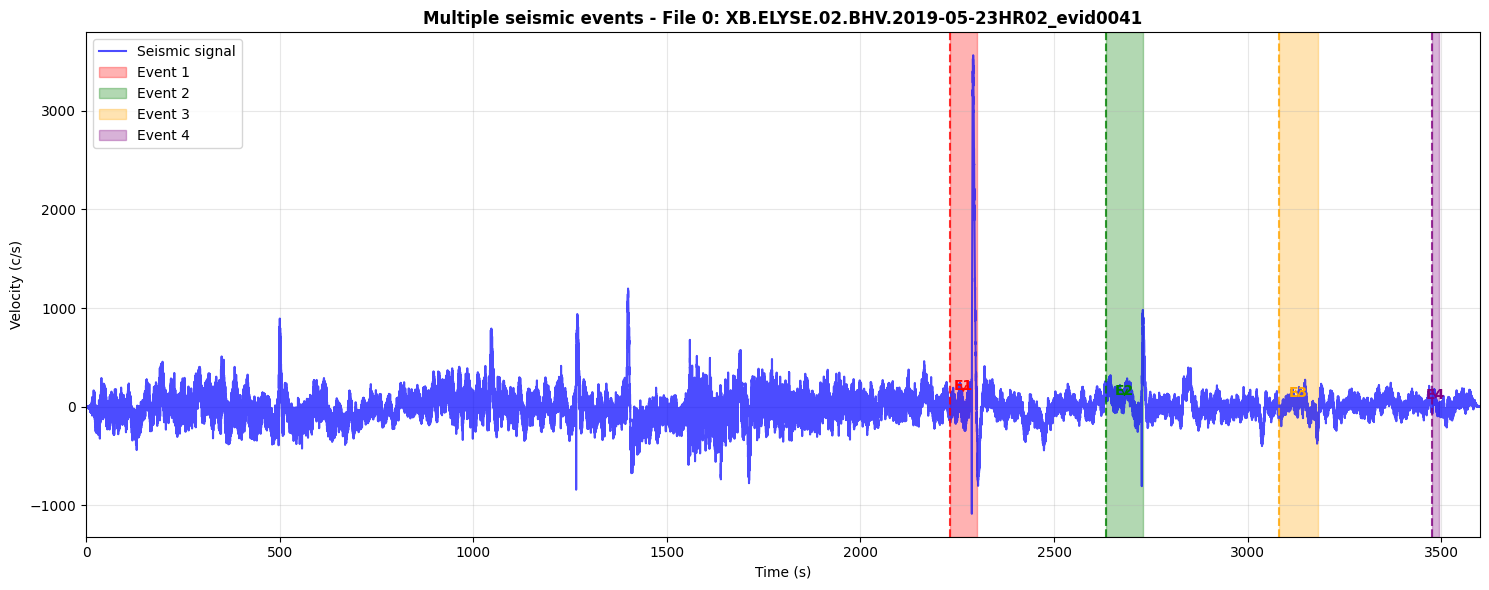



Plotting file 1: XB.ELYSE.02.BHV.2019-07-26HR12_evid0033


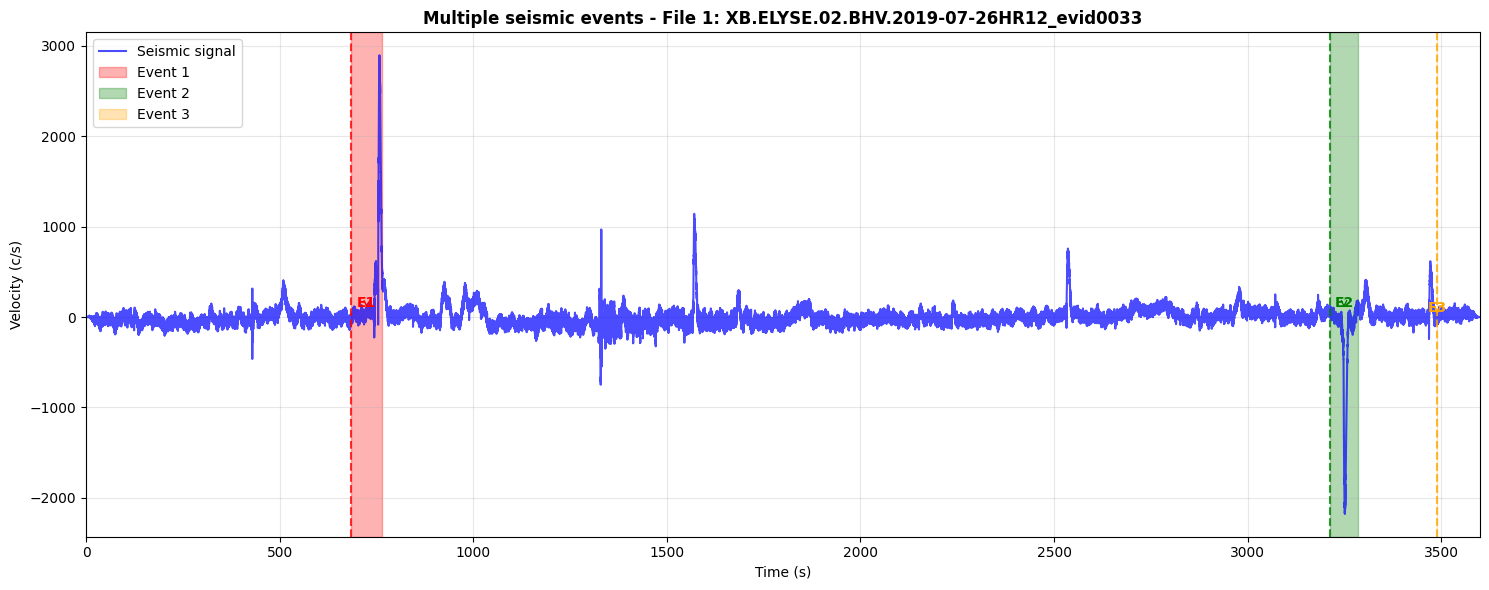



Plotting file 2: XB.ELYSE.02.BHV.2019-07-26HR12_evid0034


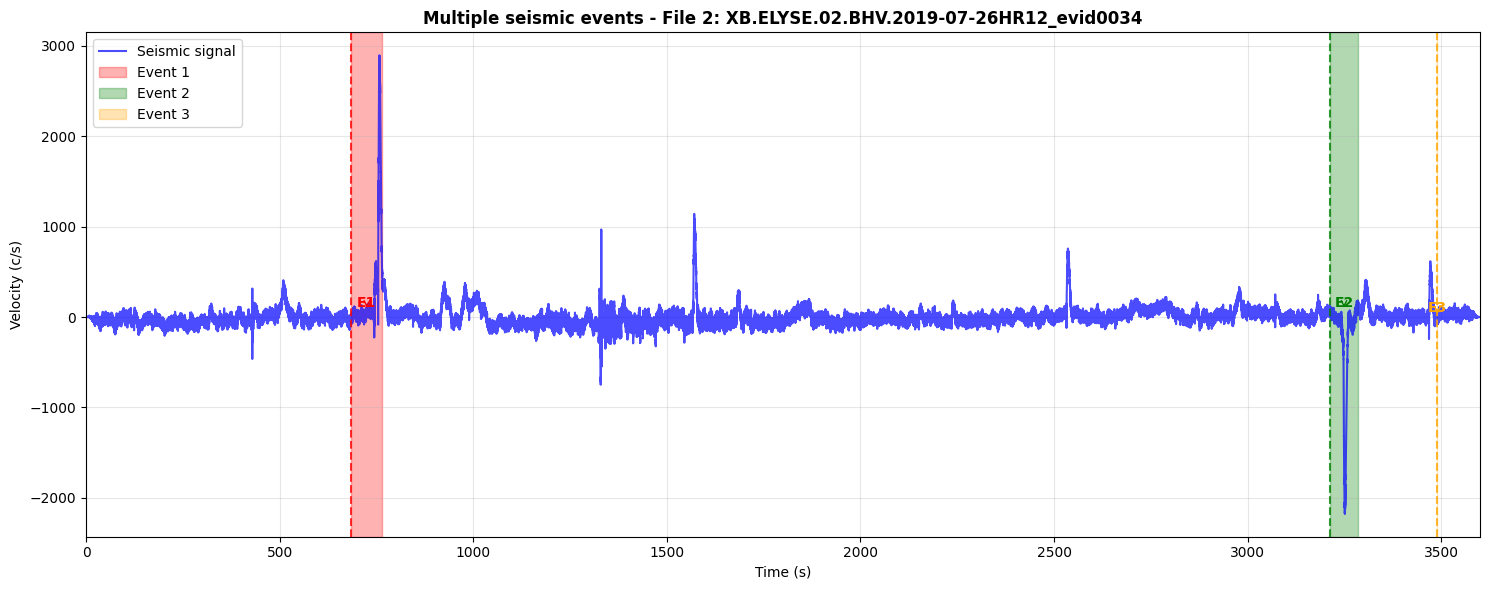



Plotting file 3: XB.ELYSE.02.BHV.2019-09-21HR03_evid0032


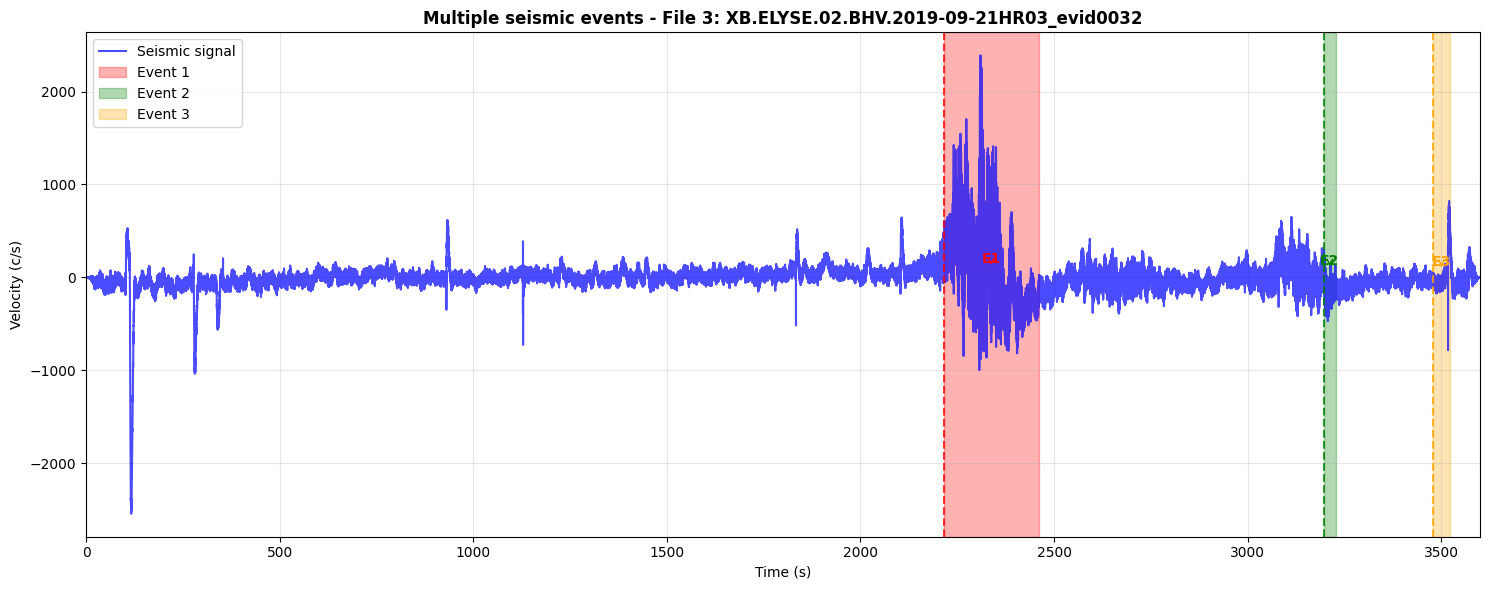



Plotting file 5: XB.ELYSE.02.BHV.2021-10-11HR23_evid0011


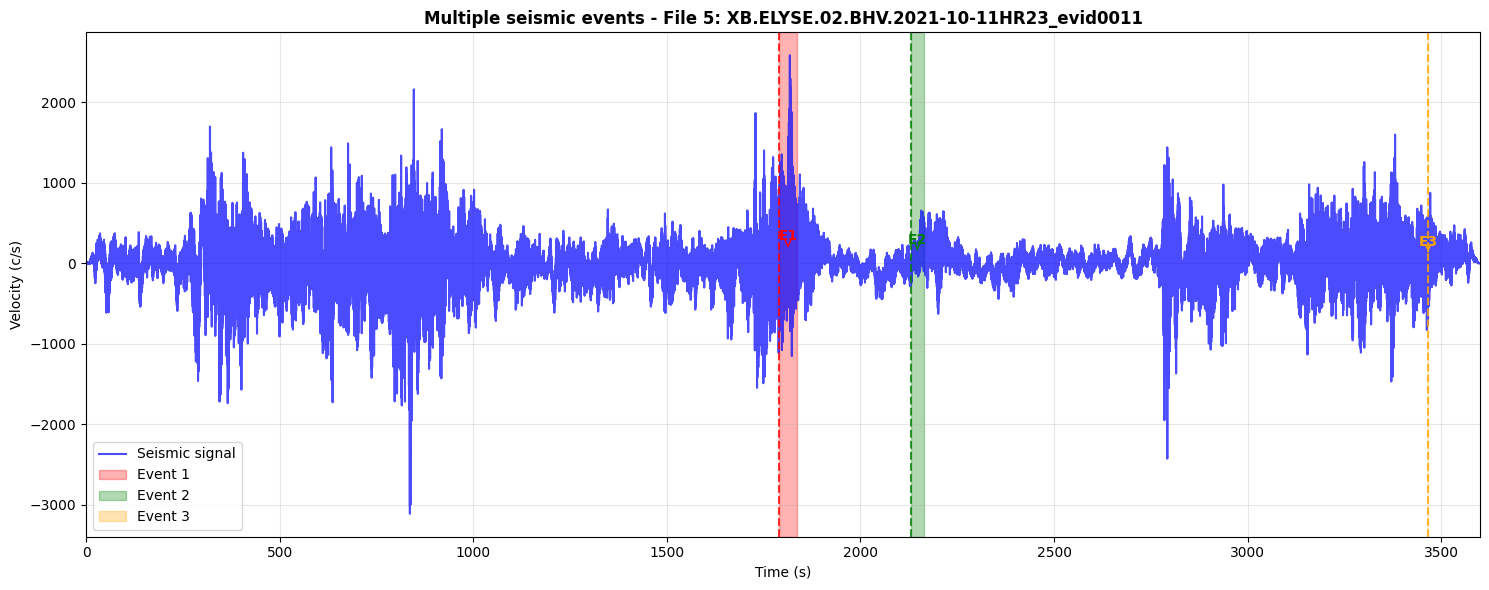



Plotting file 7: XB.ELYSE.02.BHV.2022-04-09HR22_evid0002


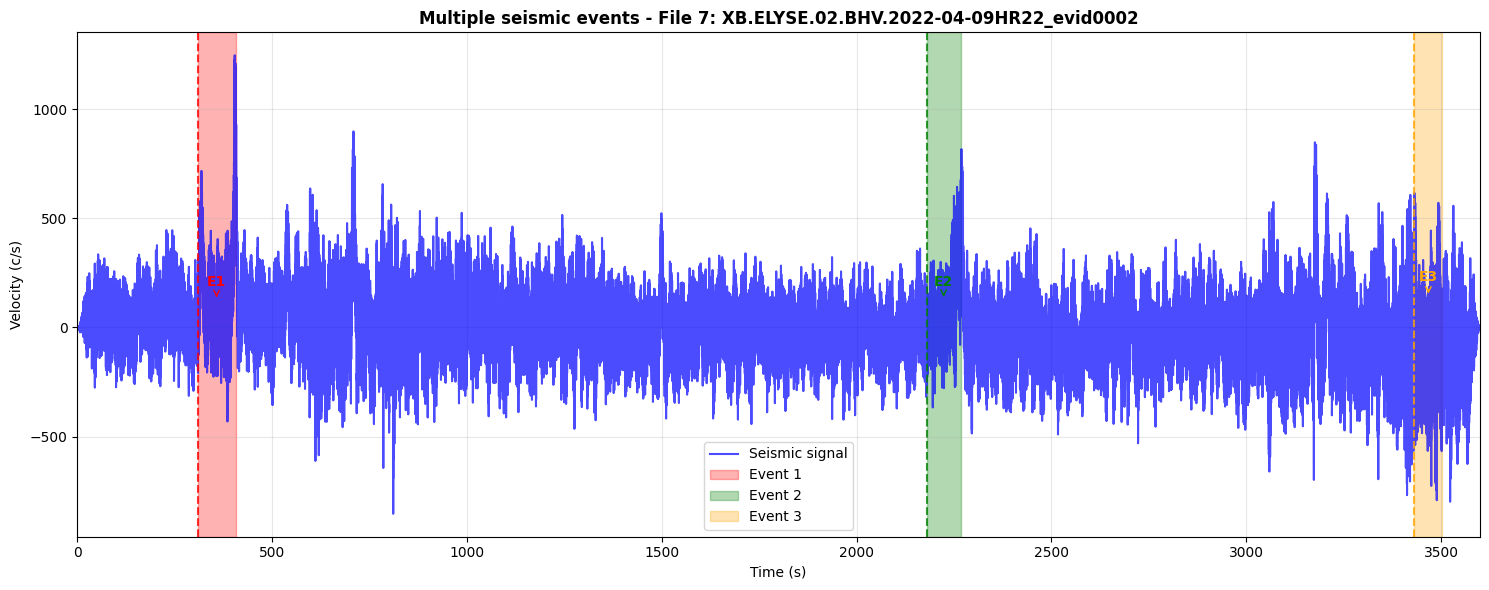



Plotting file 8: XB.ELYSE.02.BHV.2022-05-04HR23_evid0001


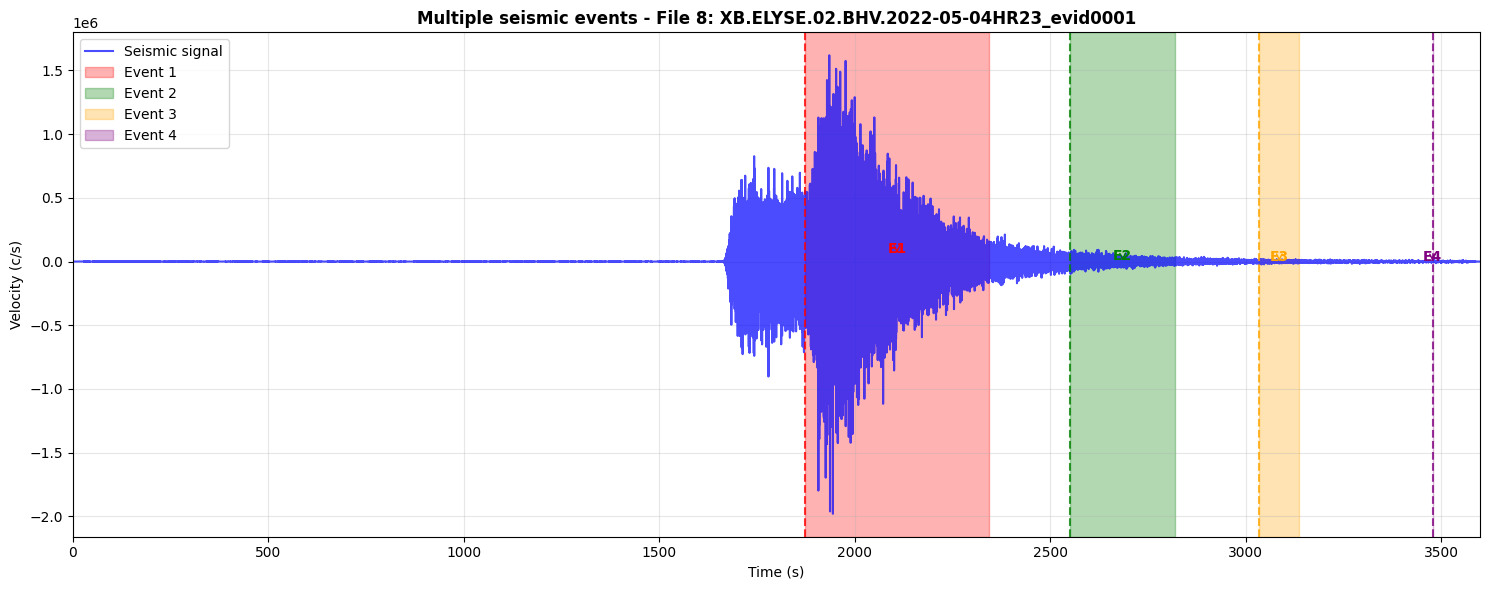

In [49]:
# Main execution
print("\n=== COMPLETE ANALYSIS ===")
multiple_events_files = find_all_multiple_events()
plot_all_multiple_events(multiple_events_files)

### Main Analysis Execution

This section demonstrates how to use the multiple event detection system for Mars seismic data. The code is structured to allow both individual file analysis and comprehensive dataset scanning.

#### Execution Options:

1. **Individual File Analysis**:
   - Analyzes a specific Mars test file
   - Generates detailed event report
   - Creates visualization plot

2. **Complete Dataset Analysis** (active code):
   - Scans all Mars test files
   - Identifies files containing multiple events
   - Generates summary statistics
   - Creates visualization plots for multi-event files

#### Expected Results:
- Console output showing Mars analysis progress
- Summary of Mars files containing multiple events
- Automatic plot generation for interesting Mars cases
- Performance metrics and processing time estimates for Mars data

Start event window: 44610


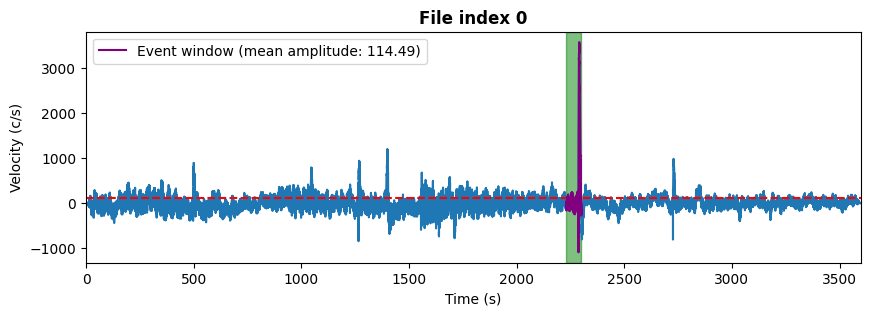

Start event window: 13710


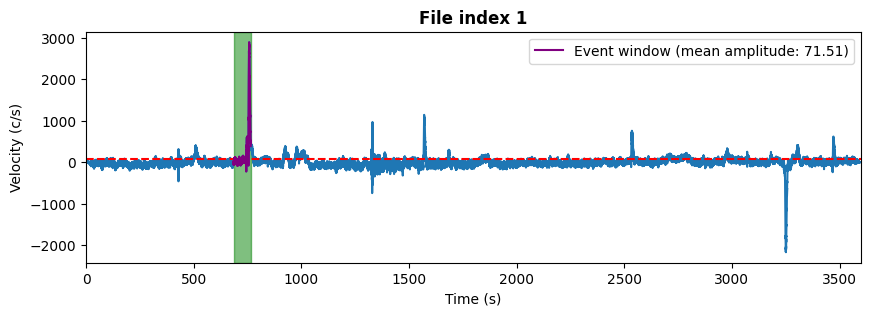

Start event window: 13710


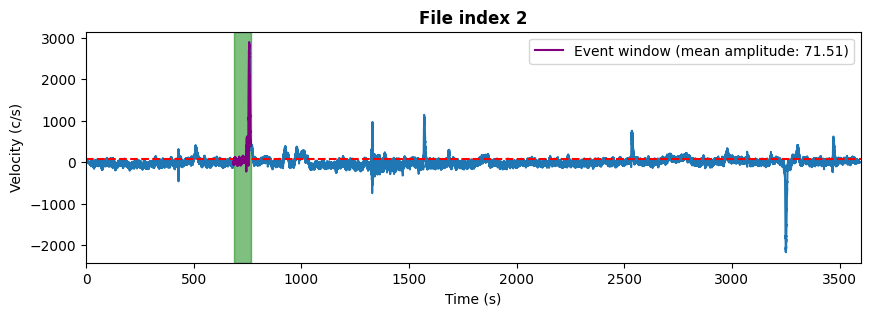

Start event window: 44310


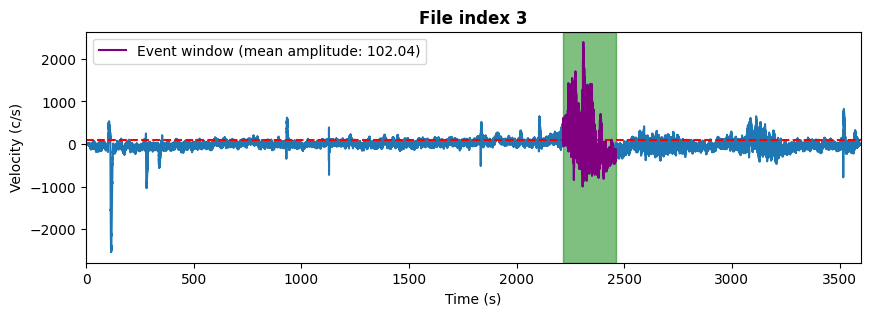

Start event window: 69300


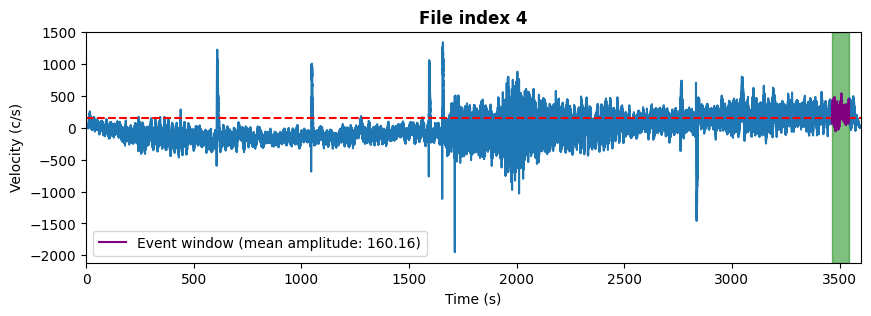

Start event window: 35790


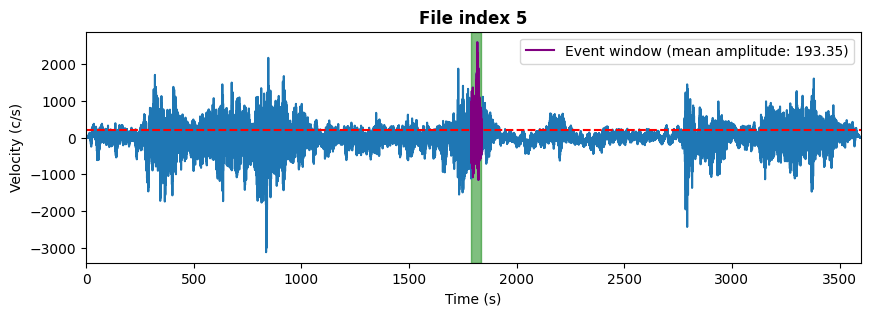

Start event window: 61560


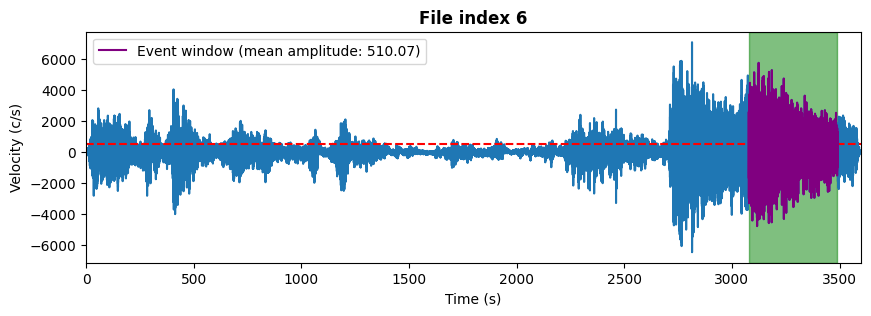

Start event window: 6180


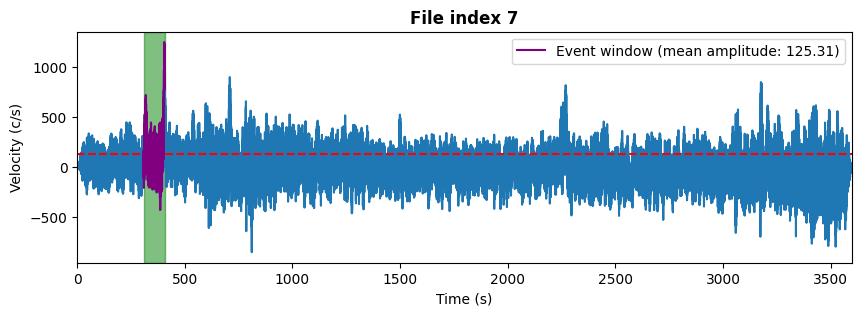

Start event window: 37440


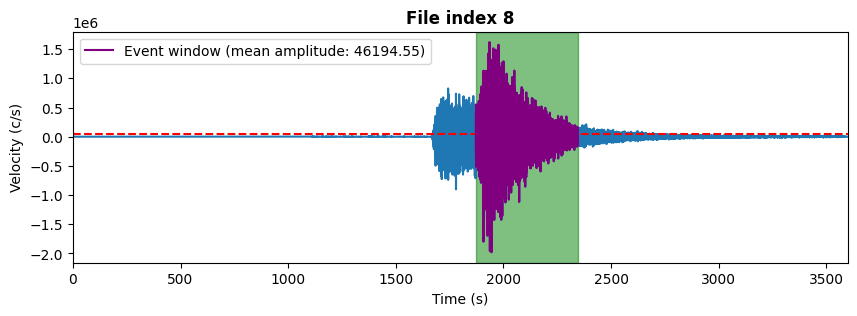

In [50]:
for n in range(0, len(cat)):
    plot_test(n)

### Comprehensive Testing Loop

This loop systematically tests the event detection algorithm on all Mars test files, providing a complete overview of algorithm performance across the entire Mars dataset.

#### Testing Process:
- **Scope**: All Mars test files in the dataset
- **Output**: Individual plot for each file showing:
  - Original Mars seismic signal
  - Detected event boundaries
  - Event characteristics
  - Algorithm performance metrics

#### Benefits:
- **Algorithm Validation**: Verify detection accuracy across diverse Mars seismic signals
- **Parameter Optimization**: Identify optimal detection thresholds for Mars data
- **Quality Assessment**: Visual inspection of Mars detection quality
- **Data Exploration**: Understand variety in Mars seismic data characteristics

In [27]:

get_noiseless_data_from_file(f'./data/mars/test/data/XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.csv')

,time,data
44610,2230.50,-38.387039
44611,2230.55,12.617777
44612,2230.60,33.622597
44613,2230.65,5.627417
44614,2230.70,23.632236
...,...,...
46015,2300.75,-256.615631
46016,2300.80,-177.610809
46017,2300.85,-163.605988
46018,2300.90,-232.601166


### Noise Removal Demonstration

This section demonstrates the noise removal capabilities of the event detection system by processing a specific Mars test file and displaying the cleaned seismic data.

#### Process:
1. **File Selection**: Uses a specific Mars test file as example
2. **Noise Removal**: Applies `get_noiseless_data_from_file()` function
3. **Visualization**: Shows the cleaned Mars seismic signal
4. **Data Display**: Shows the processed DataFrame structure

#### Purpose:
- **Data Cleaning**: Remove background noise and artifacts from Mars data
- **Event Isolation**: Extract only the seismic event portion
- **Quality Improvement**: Enhance signal-to-noise ratio for Mars analysis
- **Preprocessing**: Prepare Mars data for further scientific analysis